# <span style="font-family:Courier New; color:#CCCCCC">**Named Entity Recognition CRF**</span>

## <span style="font-family:Courier New; color:#336666">**Load Data and Imports**</span>

In [1]:
from preprocessing import convert_BIO
from NER_evaluation import *
from feature_getter import Feature_getter
import pycrfsuite
from collections import Counter
import pandas as pd
import joblib

import nltk
nltk.download('conll2002')
from nltk.corpus import conll2002

#Dutch Data
ned_train = conll2002.iob_sents('ned.train')
ned_test = conll2002.iob_sents('ned.testb')

#Spanish Data
esp_train = conll2002.iob_sents('esp.train')
esp_test = conll2002.iob_sents('esp.testb')

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\jerez\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


## <span style="font-family:Courier New; color:#336666">**Preprocessing Data**</span>

In [2]:
#Dutch
ned_train_BIO = convert_BIO(ned_train)
ned_test_BIO = convert_BIO(ned_test)

X_ned_test_BIO = [[word[0] for word in sent] for sent in ned_test_BIO]
y_ned_test_BIO = [[word[1] for word in sent] for sent in ned_test_BIO]

In [3]:
#Spanish
esp_train_BIO = convert_BIO(esp_train)
esp_test_BIO = convert_BIO(esp_test)

X_esp_test_BIO = [[word[0] for word in sent] for sent in esp_test_BIO]
y_esp_test_BIO = [[word[1] for word in sent] for sent in esp_test_BIO]

## <span style="font-family:Courier New; color:#336666">**Train Classifier**</span>

In [4]:
#Summary avaluation tables
results_esp = pd.DataFrame()
results_ned = pd.DataFrame()
def save_ent_results(nclf, results, results_agg_ent, df):
    df.loc[nclf,'total acc'] = results["precision"]
    df.loc[nclf,'total recall'] = results["recall"]
    df.loc[nclf,'total F1'] = results["F1-score"]
    df.loc[nclf,'PER F1'] = results_agg_ent["PER"]["F1-score"]
    df.loc[nclf,'ORG F1'] = results_agg_ent["ORG"]["F1-score"]
    df.loc[nclf,'LOC F1'] = results_agg_ent["LOC"]["F1-score"]
    df.loc[nclf,'MISC F1'] = results_agg_ent["MISC"]["F1-score"]
    return df

### <span style="font-family:Courier New; color:#336633">**Dutch Classifier**</span>

<span style="font-family:Courier New">Hyper&feature_opt-ned notebook suggests a model with our customed Feature Getter (not considering Next token features), for which best hyperparamaters are: {'c1': 0.01, 'c2': 0.1, 'max_iterations': 200, 'possible_transitions': True, 'possible_states': True, 'min_freq' = 0}. </span>

In [5]:
default_hyperparams = {'c1': 0.01, 'c2': 0.1, 'max_iterations': 50, 'feature.possible_transitions': True,
                                            'feature.possible_states': True, 'feature.minfreq': 0}
model = nltk.tag.CRFTagger(feature_func = Feature_getter(language='ned', next_tok=False), training_opt = default_hyperparams)
model.train(ned_train_BIO, 'models/dutch_tagger.pkl')

#### <span style="font-family:Courier New; color:#994C00">**Evalutation**</span>

In [6]:
pred_ned_BIO = model.tag_sents(X_ned_test_BIO)
y_pred_BIO = [[word[1] for word in sent] for sent in pred_ned_BIO]

print(bio_classification_report(y_ned_test_BIO, y_pred_BIO))
print('='*80)
print('Entity level evaluation')
print('='*80)
results, results_agg_ent = compute_metrics(ned_test_BIO, pred_ned_BIO)
results_ned = save_ent_results("Dutch_BIO", results, results_agg_ent, results_ned)
results_ned

              precision    recall  f1-score   support

       B-LOC       0.87      0.81      0.84       774
       I-LOC       0.67      0.53      0.59        49
      B-MISC       0.87      0.76      0.81      1187
      I-MISC       0.63      0.46      0.53       410
       B-ORG       0.81      0.71      0.76       882
       I-ORG       0.80      0.65      0.72       551
       B-PER       0.78      0.90      0.83      1098
       I-PER       0.87      0.96      0.91       807

   micro avg       0.82      0.78      0.80      5758
   macro avg       0.79      0.72      0.75      5758
weighted avg       0.82      0.78      0.79      5758
 samples avg       0.07      0.07      0.07      5758

Entity level evaluation


,total acc,total recall,total F1,PER F1,ORG F1,LOC F1,MISC F1
Dutch_BIO,0.814,0.789,0.801,0.777,0.769,0.867,0.811


#### <span style="font-family:Courier New; color:#994C00">**Feature Importance**</span>

In [18]:
def print_state_features(state_features):
        for (attr, label), weight in state_features:
            string = "%0.3f %-6s %s" % (weight, label, attr)
            print(string, end = " "*(40 - len(string)))

def feature_importance(model):

    info = model._tagger.info()
    positive_features = Counter(info.state_features).most_common(10)
    negative_features = Counter(info.state_features).most_common()[-10:]

    print("Top positive:                       |     Top negative:")
    print("-----------------------------------------------------------------------------")

    for positive, negative in zip(positive_features, negative_features):
        print_state_features([positive])
        print_state_features([negative])
        print()
feature_importance(model)

Top positive:                       |     Top negative:
-----------------------------------------------------------------------------
5.861 O      PUNCTUATION                -1.943 O      WORD_Gent                 
5.023 O      SHAPE_xxxx                 -2.064 O      SUF_our                   
3.713 B-LOC  WORD_Gent                  -2.158 B-PER  SHAPE_xxxx                
3.346 B-MISC SHAPE_XXX-xxxx             -2.177 O      LEMMA_groenen             
3.298 O      WORD_.                     -2.288 B-PER  HAS_NUM                   
3.274 O      SHAPE_xxxx-xxxx            -2.395 O      -1_SHAPE_xxx              
3.091 O      POS_PUNCT                  -2.532 B-MISC POS_INTJ                  
2.977 O      HAS_NUM                    -2.537 I-MISC -1_SUF_se                 
2.622 O      SHAPE_XXXX                 -2.590 B-LOC  SHAPE_xxxx                
2.552 O      POS_ADV                    -2.755 B-ORG  SHAPE_xxxx                


### <span style="font-family:Courier New; color:#336633">**Spanish Classifier**</span>

<span style="font-family:Courier New">Hyper&feature_opt-esp notebook suggests a model   with our customed Feature Getter consideting all features, for which best hyperparamaters are: {'c1': 0.01, 'c2': 0.1, 'max_iterations': 200, 'possible_transitions': False, 'possible_states': True, 'min_freq' = 0}.

In [9]:
customed_hyperparams = {'c1': 0.01, 'c2': 1, 'max_iterations': 200, 'feature.possible_transitions': False,
                                            'feature.possible_states': True, 'feature.minfreq': 0}
model = nltk.tag.CRFTagger(feature_func=Feature_getter(), training_opt = customed_hyperparams)
model.train(esp_train_BIO, 'models/model.crf.tagger')

#### <span style="font-family:Courier New; color:#994C00">**Evalutation**</span>

In [10]:
pred_esp_BIO = model.tag_sents(X_esp_test_BIO)
y_pred_BIO = [[word[1] for word in sent] for sent in pred_esp_BIO]

print(bio_classification_report(y_esp_test_BIO, y_pred_BIO))
print('='*80)
print('Entity level evaluation')
print('='*80)
results, results_agg_ent = compute_metrics(esp_test_BIO, pred_esp_BIO)
results_esp = save_ent_results("Spanish_BIO", results, results_agg_ent, results_esp)
results_esp

              precision    recall  f1-score   support

       B-LOC       0.80      0.79      0.79      1084
       I-LOC       0.65      0.65      0.65       325
      B-MISC       0.69      0.52      0.59       339
      I-MISC       0.66      0.53      0.59       557
       B-ORG       0.81      0.84      0.83      1400
       I-ORG       0.83      0.79      0.81      1104
       B-PER       0.85      0.89      0.87       735
       I-PER       0.90      0.95      0.92       634

   micro avg       0.80      0.78      0.79      6178
   macro avg       0.78      0.74      0.76      6178
weighted avg       0.80      0.78      0.79      6178
 samples avg       0.09      0.09      0.09      6178

Entity level evaluation


,total acc,total recall,total F1,PER F1,ORG F1,LOC F1,MISC F1
Spanish_BIO,0.797,0.792,0.795,0.853,0.796,0.79,0.65


#### <span style="font-family:Courier New; color:#994C00">**Feature Importance**</span>

In [11]:
feature_importance(model)

Top positive:                       |     Top negative:
-----------------------------------------------------------------------------
3.518 O      WORD_.                     -1.334 B-ORG  SHAPE_Xxxx                
3.040 O      PUNCTUATION                -1.354 I-ORG  PUNCTUATION               
2.558 O      SHAPE_xxxx                 -1.393 B-MISC -1_WORD_.                 
2.148 I-MISC -1_WORD_.                  -1.407 B-PER  -1_WORD_.                 
2.137 O      HAS_NUM                    -1.414 B-ORG  -1_WORD_.                 
2.065 I-ORG  -1_WORD_.                  -1.482 O      POS_PROPN                 
2.059 O      +1_CAPITALIZATION          -1.537 I-MISC WORD_.                    
1.722 O      POS_ADV                    -1.594 O      -1_POS_ADP                
1.717 I-ORG  -1_PUNCTUATION             -2.113 O      -1_WORD_.                 
1.650 B-MISC HAS_NUM                    -4.317 O      CAPITALIZATION            


<div class="alert alert-block alert-info">
<b>See:</b> We can see how both models have ≈ 0.8 F1. Tables show that dutch model performs a little better on the test set. On feature selection, we can see that dutch model relies heavily on the shape feature we have included. On the other side, we can see how spanish model relies in punctuations.
</div>

## <span style="font-family:Courier New; color:#336666">**Changing Tagger Format**</span>

<span style="font-family:Courier New">At this point, lets check whether changing the codification of entities has a postive impact on performance. </span>

### <span style="font-family:Courier New; color:#336633">**Dutch Classifier**</span>

#### <span style="font-family:Courier New; color:#994C00">**IO**</span>

In [12]:
ned_train_IO = convert_BIO(ned_train, begin = False)
ned_test_IO = convert_BIO(ned_test, begin = False)

X_ned_test_IO = [[word[0] for word in sent] for sent in ned_test_IO]
y_ned_test_IO = [[word[1] for word in sent] for sent in ned_test_IO]

In [13]:
default_hyperparams = {'c1': 0.01, 'c2': 0.1, 'max_iterations': 50, 'feature.possible_transitions': True,
                                            'feature.possible_states': True, 'feature.minfreq': 0}
model = nltk.tag.CRFTagger(feature_func = Feature_getter(language='ned', next_tok=False), training_opt = default_hyperparams)
model.train(ned_train_IO, 'models/model.crf.tagger')

In [14]:
pred_ned_IO = model.tag_sents(X_ned_test_IO)
y_pred_IO = [[word[1] for word in sent] for sent in pred_ned_IO]

print(bio_classification_report(y_ned_test_IO, y_pred_IO))
print('='*80)
print('Entity level evaluation')
print('='*80)
results, results_agg_ent = compute_metrics(ned_test_IO, pred_ned_IO)
results_ned = save_ent_results("Dutch_IO", results, results_agg_ent, results_ned)
results_ned

              precision    recall  f1-score   support

       I-LOC       0.80      0.81      0.80       823
      I-MISC       0.77      0.66      0.71      1597
       I-ORG       0.81      0.66      0.73      1433
       I-PER       0.82      0.92      0.87      1905

   micro avg       0.80      0.77      0.78      5758
   macro avg       0.80      0.76      0.78      5758
weighted avg       0.80      0.77      0.78      5758
 samples avg       0.06      0.06      0.06      5758

Entity level evaluation


,total acc,total recall,total F1,PER F1,ORG F1,LOC F1,MISC F1
Dutch_BIO,0.814,0.789,0.801,0.777,0.769,0.867,0.811
Dutch_IO,0.792,0.758,0.775,0.774,0.741,0.830,0.761


#### <span style="font-family:Courier New; color:#994C00">**BIOS**</span>

In [15]:
ned_train_BIOS = convert_BIO(ned_train, begin = True, single = True)
ned_test_BIOS = convert_BIO(ned_test, begin = True, single = True)

X_ned_test_BIOS = [[word[0] for word in sent] for sent in ned_test_BIOS]
y_ned_test_BIOS = [[word[1] for word in sent] for sent in ned_test_BIOS]

In [16]:
default_hyperparams = {'c1': 0.01, 'c2': 0.1, 'max_iterations': 50, 'feature.possible_transitions': True,
                                            'feature.possible_states': True, 'feature.minfreq': 0}
model = nltk.tag.CRFTagger(feature_func = Feature_getter(language='ned', next_tok=False), training_opt = default_hyperparams)
model.train(ned_train_BIOS, 'models/model.crf.tagger')

In [17]:
pred_ned_BIOS = model.tag_sents(X_ned_test_BIOS)
y_pred_BIOS = [[word[1] for word in sent] for sent in pred_ned_BIOS]

print(bio_classification_report(y_ned_test_BIOS, y_pred_BIOS))
print('='*80)
print('Entity level evaluation')
print('='*80)
results, results_agg_ent = compute_metrics(ned_test_BIOS, pred_ned_BIOS)
results_ned = save_ent_results("Dutch_BIOS", results, results_agg_ent, results_ned)
results_ned

              precision    recall  f1-score   support

       B-LOC       0.68      0.43      0.53        60
       I-LOC       0.67      0.53      0.59        49
       S-LOC       0.89      0.85      0.87       714
      B-MISC       0.75      0.52      0.61       372
      I-MISC       0.61      0.45      0.52       410
      S-MISC       0.86      0.81      0.84       815
       B-ORG       0.79      0.70      0.74       430
       I-ORG       0.80      0.63      0.71       551
       S-ORG       0.75      0.67      0.71       452
       B-PER       0.85      0.93      0.89       708
       I-PER       0.86      0.96      0.91       807
       S-PER       0.65      0.81      0.72       390

   micro avg       0.80      0.77      0.78      5758
   macro avg       0.76      0.69      0.72      5758
weighted avg       0.80      0.77      0.78      5758
 samples avg       0.06      0.06      0.06      5758

Entity level evaluation


,total acc,total recall,total F1,PER F1,ORG F1,LOC F1,MISC F1
Dutch_BIO,0.814,0.789,0.801,0.777,0.769,0.867,0.811
Dutch_IO,0.792,0.758,0.775,0.774,0.741,0.830,0.761
Dutch_BIOS,0.810,0.784,0.797,0.775,0.752,0.876,0.804


#### <span style="font-family:Courier New; color:#994C00">**BIOES**</span>

In [18]:
ned_train_BIOES = convert_BIO(ned_train, begin = True, single = True, end = True)
ned_test_BIOES = convert_BIO(ned_test, begin = True, single = True, end = True)

X_ned_test_BIOES = [[word[0] for word in sent] for sent in ned_test_BIOES]
y_ned_test_BIOES = [[word[1] for word in sent] for sent in ned_test_BIOES]

In [19]:
default_hyperparams = {'c1': 0.01, 'c2': 0.1, 'max_iterations': 50, 'feature.possible_transitions': True,
                                            'feature.possible_states': True, 'feature.minfreq': 0}
model = nltk.tag.CRFTagger(feature_func = Feature_getter(language='ned', next_tok=False), training_opt = default_hyperparams)
model.train(ned_train_BIOES, 'models/model.crf.tagger')

In [20]:
pred_ned_BIOES = model.tag_sents(X_ned_test_BIOES)
y_pred_BIOES = [[word[1] for word in sent] for sent in pred_ned_BIOES]

print(bio_classification_report(y_ned_test_BIOES, y_pred_BIOES))
print('='*80)
print('Entity level evaluation')
print('='*80)
results, results_agg_ent = compute_metrics(ned_test_BIOES, pred_ned_BIOES)
results_ned = save_ent_results("Dutch_BIOES", results, results_agg_ent, results_ned)
results_ned

              precision    recall  f1-score   support

       B-LOC       0.69      0.45      0.55        60
       E-LOC       0.69      0.57      0.62        42
       I-LOC       0.33      0.14      0.20         7
       S-LOC       0.88      0.86      0.87       714
      B-MISC       0.74      0.51      0.60       372
      E-MISC       0.68      0.47      0.55       260
      I-MISC       0.46      0.35      0.39       150
      S-MISC       0.87      0.81      0.84       815
       B-ORG       0.78      0.70      0.74       430
       E-ORG       0.80      0.73      0.76       399
       I-ORG       0.62      0.30      0.40       152
       S-ORG       0.74      0.68      0.71       452
       B-PER       0.86      0.94      0.90       708
       E-PER       0.86      0.96      0.91       690
       I-PER       0.87      0.89      0.88       117
       S-PER       0.66      0.81      0.72       390

   micro avg       0.80      0.76      0.78      5758
   macro avg       0.72   

,total acc,total recall,total F1,PER F1,ORG F1,LOC F1,MISC F1
Dutch_BIO,0.814,0.789,0.801,0.777,0.769,0.867,0.811
Dutch_IO,0.792,0.758,0.775,0.774,0.741,0.830,0.761
Dutch_BIOS,0.810,0.784,0.797,0.775,0.752,0.876,0.804
Dutch_BIOES,0.811,0.787,0.799,0.784,0.747,0.874,0.804


<span style="font-family:Courier New">As we can see, the codification that works best is BIO, with the higher F1-score. On the other side, we find that IO is the worst, surely because of its lack of information. What is sure is that adding 'Single' label turns out in good models. This points us that there are plenty of single token entities. Further actions could be taken with this type of models, but we will continue in the same line, with the BIO model.</span>

### <span style="font-family:Courier New; color:#336633">**Spanish Classifier**</span>

#### <span style="font-family:Courier New; color:#994C00">**IO**</span>

In [21]:
esp_train_IO = convert_BIO(esp_train, begin = False)
esp_test_IO = convert_BIO(esp_test, begin = False)

X_esp_test_IO = [[word[0] for word in sent] for sent in esp_test_IO]
y_esp_test_IO = [[word[1] for word in sent] for sent in esp_test_IO]

In [22]:
customed_hyperparams = {'c1': 0.01, 'c2': 1, 'max_iterations': 200, 'feature.possible_transitions': False,
                                            'feature.possible_states': True, 'feature.minfreq': 0}
model = nltk.tag.CRFTagger(feature_func=Feature_getter(), training_opt = customed_hyperparams)
model.train(esp_train_IO, 'models/model.crf.tagger')

In [23]:
pred_esp_IO = model.tag_sents(X_esp_test_IO)
y_pred_IO = [[word[1] for word in sent] for sent in pred_esp_IO]

print(bio_classification_report(y_esp_test_IO, y_pred_IO))
print('='*80)
print('Entity level evaluation')
print('='*80)
results, results_agg_ent = compute_metrics(esp_test_IO, pred_esp_IO)
results_esp = save_ent_results("Spanish_IO", results, results_agg_ent, results_esp)
results_esp

              precision    recall  f1-score   support

       I-LOC       0.79      0.75      0.77      1409
      I-MISC       0.68      0.55      0.61       896
       I-ORG       0.83      0.81      0.82      2504
       I-PER       0.84      0.92      0.88      1369

   micro avg       0.80      0.78      0.79      6178
   macro avg       0.78      0.76      0.77      6178
weighted avg       0.80      0.78      0.79      6178
 samples avg       0.09      0.09      0.09      6178

Entity level evaluation


,total acc,total recall,total F1,PER F1,ORG F1,LOC F1,MISC F1
Spanish_BIO,0.797,0.792,0.795,0.853,0.796,0.790,0.650
Spanish_IO,0.789,0.781,0.785,0.822,0.791,0.791,0.632


#### <span style="font-family:Courier New; color:#994C00">**BIOS**</span>

In [8]:
esp_train_BIOS = convert_BIO(esp_train, begin = True, single = True)
esp_test_BIOS = convert_BIO(esp_test, begin = True, single = True)

X_esp_test_BIOS = [[word[0] for word in sent] for sent in esp_test_BIOS]
y_esp_test_BIOS = [[word[1] for word in sent] for sent in esp_test_BIOS]

In [25]:
customed_hyperparams = {'c1': 0.01, 'c2': 1, 'max_iterations': 200, 'feature.possible_transitions': False,
                                            'feature.possible_states': True, 'feature.minfreq': 0}
model = nltk.tag.CRFTagger(feature_func=Feature_getter(), training_opt = customed_hyperparams)
model.train(esp_train_BIOS, 'models/model.crf.tagger')

In [26]:
pred_esp_BIOS = model.tag_sents(X_esp_test_BIOS)
y_pred_BIOS = [[word[1] for word in sent] for sent in pred_esp_BIOS]

print(bio_classification_report(y_esp_test_BIOS, y_pred_BIOS))
print('='*80)
print('Entity level evaluation')
print('='*80)
results, results_agg_ent = compute_metrics(esp_test_BIOS, pred_esp_BIOS)
results_esp = save_ent_results("Spanish_BIOS", results, results_agg_ent, results_esp)
results_esp

              precision    recall  f1-score   support

       B-LOC       0.73      0.63      0.68       196
       I-LOC       0.72      0.64      0.67       325
       S-LOC       0.82      0.82      0.82       888
      B-MISC       0.62      0.54      0.58       183
      I-MISC       0.66      0.55      0.60       557
      S-MISC       0.72      0.45      0.55       156
       B-ORG       0.85      0.78      0.81       467
       I-ORG       0.84      0.81      0.82      1104
       S-ORG       0.78      0.87      0.82       933
       B-PER       0.89      0.96      0.92       504
       I-PER       0.90      0.95      0.92       634
       S-PER       0.75      0.74      0.74       231

   micro avg       0.80      0.78      0.79      6178
   macro avg       0.77      0.73      0.74      6178
weighted avg       0.80      0.78      0.79      6178
 samples avg       0.09      0.09      0.09      6178

Entity level evaluation


,total acc,total recall,total F1,PER F1,ORG F1,LOC F1,MISC F1
Spanish_BIO,0.797,0.792,0.795,0.853,0.796,0.790,0.650
Spanish_IO,0.789,0.781,0.785,0.822,0.791,0.791,0.632
Spanish_BIOS,0.799,0.794,0.796,0.854,0.794,0.801,0.640


#### <span style="font-family:Courier New; color:#994C00">**BIOES**</span>

In [9]:
esp_train_BIOES = convert_BIO(esp_train, begin = True, single = True, end = True)
esp_test_BIOES = convert_BIO(esp_test, begin = True, single = True, end = True)

X_esp_test_BIOES = [[word[0] for word in sent] for sent in esp_test_BIOES]
y_esp_test_BIOES = [[word[1] for word in sent] for sent in esp_test_BIOES]

In [10]:
customed_hyperparams = {'c1': 0.01, 'c2': 1, 'max_iterations': 200, 'feature.possible_transitions': False,
                                            'feature.possible_states': True, 'feature.minfreq': 0}
model = nltk.tag.CRFTagger(feature_func=Feature_getter(), training_opt = customed_hyperparams)
model.train(esp_train_BIOES, 'models/spanish.crf.tagger')

In [29]:
pred_esp_BIOES = model.tag_sents(X_esp_test_BIOES)
y_pred_BIOES = [[word[1] for word in sent] for sent in pred_esp_BIOES]

print(bio_classification_report(y_esp_test_BIOES, y_pred_BIOES))
print('='*80)
print('Entity level evaluation')
print('='*80)
results, results_agg_ent = compute_metrics(esp_test_BIOES, pred_esp_BIOES)
results_esp = save_ent_results("Spanish_BIOES", results, results_agg_ent, results_esp)
results_esp

              precision    recall  f1-score   support

       B-LOC       0.73      0.65      0.69       196
       E-LOC       0.75      0.69      0.72       177
       I-LOC       0.65      0.58      0.61       148
       S-LOC       0.82      0.83      0.82       888
      B-MISC       0.66      0.52      0.59       183
      E-MISC       0.58      0.48      0.52       183
      I-MISC       0.72      0.49      0.58       374
      S-MISC       0.70      0.44      0.54       156
       B-ORG       0.85      0.78      0.81       467
       E-ORG       0.78      0.72      0.75       458
       I-ORG       0.81      0.80      0.81       646
       S-ORG       0.78      0.87      0.82       933
       B-PER       0.88      0.96      0.92       504
       E-PER       0.87      0.96      0.91       498
       I-PER       0.87      0.82      0.84       136
       S-PER       0.77      0.74      0.75       231

   micro avg       0.80      0.77      0.78      6178
   macro avg       0.76   

,total acc,total recall,total F1,PER F1,ORG F1,LOC F1,MISC F1
Spanish_BIO,0.797,0.792,0.795,0.853,0.796,0.790,0.650
Spanish_IO,0.789,0.781,0.785,0.822,0.791,0.791,0.632
Spanish_BIOS,0.799,0.794,0.796,0.854,0.794,0.801,0.640
Spanish_BIOES,0.799,0.796,0.797,0.854,0.791,0.802,0.652


<span style="font-family:Courier New">As we can see, as in the dutch model, the codification that works best is BIO, with the higher F1-score. On the other side, we find that IO is the worst, surely because of its lack of information. What is sure is that adding 'Single' label turns out in good models. This points us that there are plenty of single token entities. Further actions could be taken with this type of models, but we will continue in the same line, with the BIO model.</span>

## <span style="font-family:Courier New; color:#336666">**Language Models Comparsion**</span>

<span style="font-family:Courier New">In this section, once we have found the best models for each language, we consider opportune to make a comparison.</span>

In [10]:
dutch_hyperparams = {'c1': 0.01, 'c2': 0.1, 'max_iterations': 50, 'feature.possible_transitions': True,
                                            'feature.possible_states': True, 'feature.minfreq': 0}
dutch_model = nltk.tag.CRFTagger(feature_func = Feature_getter(language='ned', next_tok=False), training_opt = dutch_hyperparams)
dutch_model.train(ned_train_BIO, 'models/dutch.crf.tagger')

In [11]:
spanish_hyperparams = {'c1': 0.01, 'c2': 1, 'max_iterations': 200, 'feature.possible_transitions': False,
                                            'feature.possible_states': True, 'feature.minfreq': 0}
spanish_model = nltk.tag.CRFTagger(feature_func=Feature_getter(), training_opt = spanish_hyperparams)
spanish_model.train(esp_train_BIOES, 'models/spanish.crf.tagger')

### <span style="font-family:Courier New; color:#336633">**Feature Importance**</span>

In [20]:
print('Dutch Important Features')
print('='*80)
feature_importance(dutch_model)
print()
print('Spanish Important Features')
print('='*80)
feature_importance(spanish_model)

Dutch Important Features
Top positive:                       |     Top negative:
-----------------------------------------------------------------------------
5.861 O      PUNCTUATION                -1.639 O      LEMMA_gewinnensie         
5.023 O      SHAPE_xxxx                 -1.639 O      WORD_gewinnensie          
3.713 B-LOC  WORD_Gent                  -1.640 B-MISC SHAPE_xx                  
3.346 B-MISC SHAPE_XXX-xxxx             -1.641 B-MISC SHAPE_xxx                 
3.298 O      WORD_.                     -1.654 B-PER  LEN_14                    
3.274 O      SHAPE_xxxx-xxxx            -1.682 O      SUF_win                   
3.091 O      POS_PUNCT                  -1.695 O      WORD_Allen                
2.977 O      HAS_NUM                    -1.701 B-PER  -1_LEMMA_het              
2.622 O      SHAPE_XXXX                 -1.710 O      -1_POS_ADP                
2.552 O      POS_ADV                    -1.717 O      -1_PRE_pat                
2.546 B-MISC SUF_se            

### <span style="font-family:Courier New; color:#336633">**Performance**</span>

In [8]:
pred_ned_BIO = dutch_model.tag_sents(X_ned_test_BIO)
y_pred_BIO = [[word[1] for word in sent] for sent in pred_ned_BIO]

pred_esp_BIOES = spanish_model.tag_sents(X_esp_test_BIOES)
y_pred_BIOES = [[word[1] for word in sent] for sent in pred_esp_BIOES]

print('Entity level evaluation')
print('='*80)
results, results_agg_ent = compute_metrics(ned_test_BIO, pred_ned_BIO)
results_df = save_ent_results("Dutch Model", results, results_agg_ent, pd.DataFrame())

results, results_agg_ent = compute_metrics(esp_test_BIOES, pred_esp_BIOES)
results_df = save_ent_results("Spanish Model", results, results_agg_ent, results_df)
results_df

Entity level evaluation


,total acc,total recall,total F1,PER F1,ORG F1,LOC F1,MISC F1
Dutch Model,0.814,0.789,0.801,0.777,0.769,0.867,0.811
Spanish Model,0.799,0.796,0.797,0.854,0.791,0.802,0.652


==============================  DUTCH   ==============================


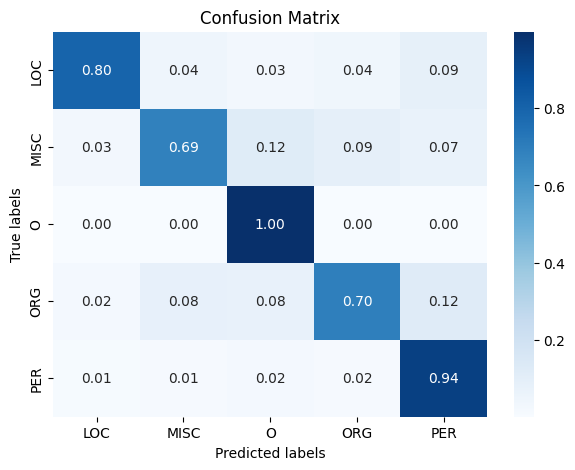

==============================  SPANISH   ==============================


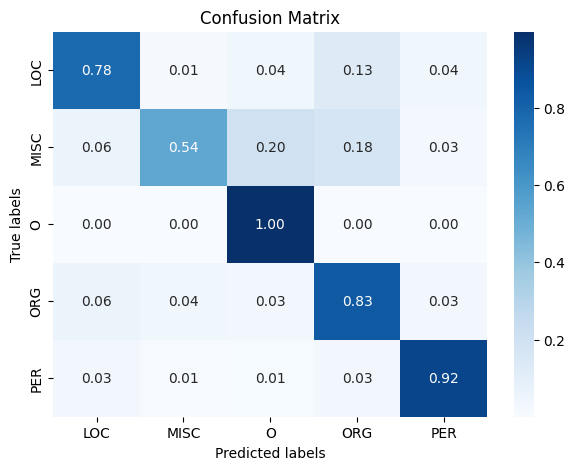

In [9]:
print('='*30 + '  DUTCH   ' + '=' * 30)
ent_confusion_matrix(y_ned_test_BIO, y_pred_BIO)
print('='*30 + '  SPANISH   ' + '=' * 30)
ent_confusion_matrix(y_esp_test_BIOES, y_pred_BIOES)